In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import gravis as gv
import csv

C:\Users\elizl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
class NW:
    def __init__(self, num_bins=10, num_boot=10):
        self.num_bins = num_bins
        self.num_boot = num_boot

    def discretize_features(self, data):
        discretizer = KBinsDiscretizer(n_bins=self.num_bins, encode='ordinal', strategy='quantile')
        return pd.DataFrame(discretizer.fit_transform(data), columns=data.columns)
    
    def mutual_information(self, data, group1_features, group2_features):
        mi_values = {}
        epsilon = 1e-10  # Small constant to avoid log(0)

        for feat_group1 in group1_features:
            for feat_group2 in group2_features:
                valid_data_group1 = data[feat_group1].fillna('').astype('category').cat.codes
                valid_data_group2 = data[feat_group2].fillna('').astype('category').cat.codes
                
                bins_group1 = np.unique(valid_data_group1).size
                bins_group2 = np.unique(valid_data_group2).size
                
                # joint probability
                joint_prob, edges = np.histogramdd(
                    np.vstack([valid_data_group1, valid_data_group2]).T,
                    bins=(bins_group1, bins_group2)
                )
                joint_prob /= np.sum(joint_prob)
                
                # marginal probabilities
                marginal_prob_group1 = np.histogram(valid_data_group1, bins=bins_group1)[0] / len(valid_data_group1)
                marginal_prob_group2 = np.histogram(valid_data_group2, bins=bins_group2)[0] / len(valid_data_group2)

                marginal_prob_group1 = marginal_prob_group1[:, None]
                marginal_prob_group2 = marginal_prob_group2[None, :]
                
                mi_matrix = joint_prob * np.log2(joint_prob / (marginal_prob_group1 * marginal_prob_group2 + epsilon) + epsilon)
                mi = np.sum(mi_matrix[np.isfinite(mi_matrix)])

                mi_values[(feat_group1, feat_group2)] = float(mi)
        
        return mi_values
    
    def bootstrap_iteration(self, data, group1_features, group2_features):
        bootstrap_sample = data.sample(frac=1, replace=True, random_state=np.random.RandomState())
        return self.mutual_information(bootstrap_sample, group1_features, group2_features)

    def bootstrap(self, data, group1_features, group2_features):
        original_mi = self.mutual_information(data, group1_features, group2_features)
        bootstrap_mis = {edge: [] for edge in original_mi.keys()}

        for _ in range(self.num_boot):
            mi_values = self.bootstrap_iteration(data, group1_features, group2_features)
            for edge, mi in mi_values.items():
                bootstrap_mis[edge].append(mi)

        p_values = {}
        for edge, mi_distribution in bootstrap_mis.items():
            original_mi_value = original_mi[edge]

            p_value = (np.sum(np.array(mi_distribution) >= original_mi_value) + 1) / (self.num_boot + 1)
            p_values[edge] = {'feat1': edge[0], 'feat2': edge[1], 'p-val': p_value}

        return original_mi, p_values

## Why am I getting large values for p-values.
## b/c the MI is small, and should be large
## the sig edges should be less thatn 0.005. but most values are over 0.2

Apply Network class

In [7]:
net = NW(num_bins=5, num_boot=10)
data = pd.read_csv('data/cleaning data/participant_combined.csv', delimiter=',')
data.drop(columns=['eid', 'Date_of_attending_assessment_centre', 'X34.0.0', 'Gender', 'Ethnicity', 'Migrant.Status', 'TDI.Tertiles', 'Highest.Qualification', 'House.Ownership', 'Income', 'Cohabiting', 'Living.Alone', 'AUDIT.Score', 'Smoker', 'Moderate.Physical.Activity', 'Longstanding.Illness', 'Diabetes', 'Cancer'], inplace=True, errors='ignore')
discrete_data = net.discretize_features(data.dropna())

values = {
    'Depression_group': ['Depressed.At.Baseline', 'Loneliness', 'Social.Isolation', 'PHQ9.No.Info', 'PHQ9.Screen', 'PHQ9.Items', 'PHQ9.Severity', 'CIDI.MDD.No.Info', 'CIDI.MDD.Screen', 'CIDI.MDD.Response', 'CIDI.MDD.Severity', 'GAD.CIDI.Somatic'],
    'CVD_group' : ['CVD'],
    'NMR_group' : [
        'Cholesterol_in_Chylomicrons_and_Extremely_Large_VLDL', 'Cholesterol_in_IDL', 'Cholesterol_in_Large_HDL', 'Cholesterol_in_Large_LDL', 'Cholesterol_in_Large_VLDL', 'Cholesterol_in_Medium_HDL', 'Cholesterol_in_Medium_LDL', 'Cholesterol_in_Medium_VLDL', 'Cholesterol_in_Small_HDL', 'Cholesterol_in_Small_LDL', 'Cholesterol_in_Small_VLDL', 'Cholesterol_in_Very_Large_HDL', 'Cholesterol_in_Very_Large_VLDL', 'Cholesterol_in_Very_Small_VLDL', 'Clinical_LDL_Cholesterol', 'HDL_Cholesterol', 'LDL_Cholesterol', 'Remnant_Cholesterol_(Non-HDL,_Non-LDL_-Cholesterol)', 'Total_Cholesterol', 'Total_Cholesterol_Minus_HDL-C', 'Total_Concentration_of_Lipoprotein_Particles', 'Total_Esterified_Cholesterol', 'VLDL_Cholesterol',
        'Cholesteryl_Esters_in_Chylomicrons_and_Extremely_Large_VLDL', 'Cholesteryl_Esters_in_HDL', 'Cholesteryl_Esters_in_IDL', 'Cholesteryl_Esters_in_Large_HDL', 'Cholesteryl_Esters_in_Large_LDL', 'Cholesteryl_Esters_in_Large_VLDL', 'Cholesteryl_Esters_in_LDL', 'Cholesteryl_Esters_in_Medium_HDL', 'Cholesteryl_Esters_in_Medium_LDL', 'Cholesteryl_Esters_in_Medium_VLDL', 'Cholesteryl_Esters_in_Small_HDL', 'Cholesteryl_Esters_in_Small_LDL', 'Cholesteryl_Esters_in_Small_VLDL', 'Cholesteryl_Esters_in_Very_Large_HDL', 'Cholesteryl_Esters_in_Very_Large_VLDL', 'Cholesteryl_Esters_in_Very_Small_VLDL', 'Cholesteryl_Esters_in_VLDL',
        'Concentration_of_Chylomicrons_and_Extremely_Large_VLDL_Particles', 'Concentration_of_HDL_Particles', 'Concentration_of_IDL_Particles', 'Concentration_of_Large_HDL_Particles', 'Concentration_of_Large_LDL_Particles', 'Concentration_of_Large_VLDL_Particles', 'Concentration_of_LDL_Particles', 'Concentration_of_Medium_HDL_Particles', 'Concentration_of_Medium_LDL_Particles', 'Concentration_of_Medium_VLDL_Particles', 'Concentration_of_Small_HDL_Particles', 'Concentration_of_Small_LDL_Particles', 'Concentration_of_Small_VLDL_Particles', 'Concentration_of_Very_Large_HDL_Particles', 'Concentration_of_Very_Large_VLDL_Particles', 'Concentration_of_Very_Small_VLDL_Particles', 'Concentration_of_VLDL_Particles', 
        'Free_Cholesterol_in_Chylomicrons_and_Extremely_Large_VLDL', 'Free_Cholesterol_in_HDL', 'Free_Cholesterol_in_IDL', 'Free_Cholesterol_in_Large_HDL', 'Free_Cholesterol_in_Large_LDL', 'Free_Cholesterol_in_Large_VLDL', 'Free_Cholesterol_in_LDL', 'Free_Cholesterol_in_Medium_HDL', 'Free_Cholesterol_in_Medium_LDL', 'Free_Cholesterol_in_Medium_VLDL', 'Free_Cholesterol_in_Small_HDL', 'Free_Cholesterol_in_Small_LDL', 'Free_Cholesterol_in_Small_VLDL', 'Free_Cholesterol_in_Very_Large_HDL', 'Free_Cholesterol_in_Very_Large_VLDL', 'Free_Cholesterol_in_Very_Small_VLDL', 'Free_Cholesterol_in_VLDL', 'Total_Free_Cholesterol',
        'Phospholipids_in_Chylomicrons_and_Extremely_Large_VLDL', 'Phospholipids_in_HDL', 'Phospholipids_in_IDL', 'Phospholipids_in_Large_HDL', 'Phospholipids_in_Large_LDL', 'Phospholipids_in_Large_VLDL', 'Phospholipids_in_LDL', 'Phospholipids_in_Medium_HDL', 'Phospholipids_in_Medium_LDL', 'Phospholipids_in_Medium_VLDL', 'Phospholipids_in_Small_HDL', 'Phospholipids_in_Small_LDL', 'Phospholipids_in_Small_VLDL', 'Phospholipids_in_Very_Large_HDL', 'Phospholipids_in_Very_Large_VLDL', 'Phospholipids_in_Very_Small_VLDL', 'Phospholipids_in_VLDL', 'Total_Phospholipids_in_Lipoprotein_Particles',
        'Total_Lipids_in_Chylomicrons_and_Extremely_Large_VLDL', 'Total_Lipids_in_HDL', 'Total_Lipids_in_IDL', 'Total_Lipids_in_Large_HDL', 'Total_Lipids_in_Large_LDL', 'Total_Lipids_in_Large_VLDL', 'Total_Lipids_in_LDL', 'Total_Lipids_in_Lipoprotein_Particles', 'Total_Lipids_in_Medium_HDL', 'Total_Lipids_in_Medium_LDL', 'Total_Lipids_in_Medium_VLDL', 'Total_Lipids_in_Small_HDL', 'Total_Lipids_in_Small_LDL', 'Total_Lipids_in_Small_VLDL', 'Total_Lipids_in_Very_Large_HDL', 'Total_Lipids_in_Very_Large_VLDL', 'Total_Lipids_in_Very_Small_VLDL', 'Total_Lipids_in_VLDL',
        'Total_Triglycerides', 'Triglycerides_in_Chylomicrons_and_Extremely_Large_VLDL', 'Triglycerides_in_HDL', 'Triglycerides_in_IDL', 'Triglycerides_in_Large_HDL', 'Triglycerides_in_Large_LDL', 'Triglycerides_in_Large_VLDL', 'Triglycerides_in_LDL', 'Triglycerides_in_Medium_HDL', 'Triglycerides_in_Medium_LDL', 'Triglycerides_in_Medium_VLDL', 'Triglycerides_in_Small_HDL', 'Triglycerides_in_Small_LDL', 'Triglycerides_in_Small_VLDL', 'Triglycerides_in_Very_Large_HDL', 'Triglycerides_in_Very_Large_VLDL', 'Triglycerides_in_Very_Small_VLDL', 'Triglycerides_in_VLDL',
        'Apolipoprotein_A1', 'Apolipoprotein_B', 'Average_Diameter_for_HDL_Particles', 'Average_Diameter_for_LDL_Particles', 'Average_Diameter_for_VLDL_Particles', 'Glycoprotein_Acetyls'
    ]
}

# Depression v NMR
mi_depr_nmr, p_val_depr_nmr = net.bootstrap(discrete_data, values['Depression_group'], values['NMR_group'])
print("Mutual Information Values Depression:", mi_depr_nmr)
print("Depr P-Values:", p_val_depr_nmr)
# mi_list_depr = [mi for mi in mi_depr_nmr]
mi_list_depr = [mi for mi in mi_depr_nmr.values()]

# CVD v NMR
mi_cvd_nmr, p_val_cvd_nmr = net.bootstrap(discrete_data, values['CVD_group'], values['NMR_group'])
print("Mutual Information Values CVD:", mi_cvd_nmr)
print("CVD P-Values:", p_val_cvd_nmr)
# mi_list_cvd = [mi for mi in mi_cvd_nmr]
mi_list_cvd = [mi for mi in mi_cvd_nmr.values()]

# 10 bts~ 58 min
# or 18min? haha
# 28min  for dep

C:\Users\elizl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\elizl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\elizl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. 

Mutual Information Values Depression: {('Depressed.At.Baseline', 'Cholesterol_in_Chylomicrons_and_Extremely_Large_VLDL'): -1.442695131001411e-10, ('Depressed.At.Baseline', 'Cholesterol_in_IDL'): -1.4426949926064305e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Large_HDL'): -1.4426954558715418e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Large_LDL'): -1.4426952865650404e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Large_VLDL'): -1.4426950500682158e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Medium_HDL'): -1.4426954249159358e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Medium_LDL'): -1.4426954805040816e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Medium_VLDL'): -1.4426954805039327e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Small_HDL'): -1.4426954793825865e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Small_LDL'): -1.4426943944926154e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Small_VLDL'): -1.442695560977688e-10, ('Depressed.At.Baseline', 'Cholesterol_in_Very_Large_HD

Saving to CSV

In [8]:
depr_nmr_results = []
for edge, mi in mi_depr_nmr.items():
    p_val = p_val_depr_nmr[edge]['p-val']
    depr_nmr_results.append({
        'Depression Attribute': edge[0],
        'NMR Attribute': edge[1],
        'Mutual Information': mi,
        'P-Value': p_val
    })

df_depr_nmr = pd.DataFrame(depr_nmr_results)

cvd_nmr_results = []
for edge, mi in mi_cvd_nmr.items():
    p_val = p_val_cvd_nmr[edge]['p-val']
    cvd_nmr_results.append({
        'CVD Attribute': edge[0],
        'NMR Attribute': edge[1],
        'Mutual Information': mi,
        'P-Value': p_val
    })

df_cvd_nmr = pd.DataFrame(cvd_nmr_results)

df_combined = pd.concat([df_depr_nmr, df_cvd_nmr], ignore_index=True)
df_combined.to_csv('atr_p_values_10.csv', index=False)

100 times

In [ ]:
net_100 = NW(num_bins=5, num_boot=100)
data_100 = pd.read_csv('data/cleaning data/participant_combined.csv', delimiter=',')
data_100.drop(columns=['eid', 'Date_of_attending_assessment_centre', 'X34.0.0', 'Gender', 'Ethnicity', 'Migrant.Status', 'TDI.Tertiles', 'Highest.Qualification', 'House.Ownership', 'Income', 'Cohabiting', 'Living.Alone', 'AUDIT.Score', 'Smoker', 'Moderate.Physical.Activity', 'Longstanding.Illness', 'Diabetes', 'Cancer'], inplace=True, errors='ignore')
discrete_data_100 = net_100.discretize_features(data_100.dropna())

values = {
    'Depression_group': ['Depressed.At.Baseline', 'Loneliness', 'Social.Isolation', 'PHQ9.No.Info', 'PHQ9.Screen', 'PHQ9.Items', 'PHQ9.Severity', 'CIDI.MDD.No.Info', 'CIDI.MDD.Screen', 'CIDI.MDD.Response', 'CIDI.MDD.Severity', 'GAD.CIDI.Somatic'],
    'CVD_group' : ['CVD'],
    'NMR_group' : [
        'Cholesterol_in_Chylomicrons_and_Extremely_Large_VLDL', 'Cholesterol_in_IDL', 'Cholesterol_in_Large_HDL', 'Cholesterol_in_Large_LDL', 'Cholesterol_in_Large_VLDL', 'Cholesterol_in_Medium_HDL', 'Cholesterol_in_Medium_LDL', 'Cholesterol_in_Medium_VLDL', 'Cholesterol_in_Small_HDL', 'Cholesterol_in_Small_LDL', 'Cholesterol_in_Small_VLDL', 'Cholesterol_in_Very_Large_HDL', 'Cholesterol_in_Very_Large_VLDL', 'Cholesterol_in_Very_Small_VLDL', 'Clinical_LDL_Cholesterol', 'HDL_Cholesterol', 'LDL_Cholesterol', 'Remnant_Cholesterol_(Non-HDL,_Non-LDL_-Cholesterol)', 'Total_Cholesterol', 'Total_Cholesterol_Minus_HDL-C', 'Total_Concentration_of_Lipoprotein_Particles', 'Total_Esterified_Cholesterol', 'VLDL_Cholesterol',
        'Cholesteryl_Esters_in_Chylomicrons_and_Extremely_Large_VLDL', 'Cholesteryl_Esters_in_HDL', 'Cholesteryl_Esters_in_IDL', 'Cholesteryl_Esters_in_Large_HDL', 'Cholesteryl_Esters_in_Large_LDL', 'Cholesteryl_Esters_in_Large_VLDL', 'Cholesteryl_Esters_in_LDL', 'Cholesteryl_Esters_in_Medium_HDL', 'Cholesteryl_Esters_in_Medium_LDL', 'Cholesteryl_Esters_in_Medium_VLDL', 'Cholesteryl_Esters_in_Small_HDL', 'Cholesteryl_Esters_in_Small_LDL', 'Cholesteryl_Esters_in_Small_VLDL', 'Cholesteryl_Esters_in_Very_Large_HDL', 'Cholesteryl_Esters_in_Very_Large_VLDL', 'Cholesteryl_Esters_in_Very_Small_VLDL', 'Cholesteryl_Esters_in_VLDL',
        'Concentration_of_Chylomicrons_and_Extremely_Large_VLDL_Particles', 'Concentration_of_HDL_Particles', 'Concentration_of_IDL_Particles', 'Concentration_of_Large_HDL_Particles', 'Concentration_of_Large_LDL_Particles', 'Concentration_of_Large_VLDL_Particles', 'Concentration_of_LDL_Particles', 'Concentration_of_Medium_HDL_Particles', 'Concentration_of_Medium_LDL_Particles', 'Concentration_of_Medium_VLDL_Particles', 'Concentration_of_Small_HDL_Particles', 'Concentration_of_Small_LDL_Particles', 'Concentration_of_Small_VLDL_Particles', 'Concentration_of_Very_Large_HDL_Particles', 'Concentration_of_Very_Large_VLDL_Particles', 'Concentration_of_Very_Small_VLDL_Particles', 'Concentration_of_VLDL_Particles', 
        'Free_Cholesterol_in_Chylomicrons_and_Extremely_Large_VLDL', 'Free_Cholesterol_in_HDL', 'Free_Cholesterol_in_IDL', 'Free_Cholesterol_in_Large_HDL', 'Free_Cholesterol_in_Large_LDL', 'Free_Cholesterol_in_Large_VLDL', 'Free_Cholesterol_in_LDL', 'Free_Cholesterol_in_Medium_HDL', 'Free_Cholesterol_in_Medium_LDL', 'Free_Cholesterol_in_Medium_VLDL', 'Free_Cholesterol_in_Small_HDL', 'Free_Cholesterol_in_Small_LDL', 'Free_Cholesterol_in_Small_VLDL', 'Free_Cholesterol_in_Very_Large_HDL', 'Free_Cholesterol_in_Very_Large_VLDL', 'Free_Cholesterol_in_Very_Small_VLDL', 'Free_Cholesterol_in_VLDL', 'Total_Free_Cholesterol',
        'Phospholipids_in_Chylomicrons_and_Extremely_Large_VLDL', 'Phospholipids_in_HDL', 'Phospholipids_in_IDL', 'Phospholipids_in_Large_HDL', 'Phospholipids_in_Large_LDL', 'Phospholipids_in_Large_VLDL', 'Phospholipids_in_LDL', 'Phospholipids_in_Medium_HDL', 'Phospholipids_in_Medium_LDL', 'Phospholipids_in_Medium_VLDL', 'Phospholipids_in_Small_HDL', 'Phospholipids_in_Small_LDL', 'Phospholipids_in_Small_VLDL', 'Phospholipids_in_Very_Large_HDL', 'Phospholipids_in_Very_Large_VLDL', 'Phospholipids_in_Very_Small_VLDL', 'Phospholipids_in_VLDL', 'Total_Phospholipids_in_Lipoprotein_Particles',
        'Total_Lipids_in_Chylomicrons_and_Extremely_Large_VLDL', 'Total_Lipids_in_HDL', 'Total_Lipids_in_IDL', 'Total_Lipids_in_Large_HDL', 'Total_Lipids_in_Large_LDL', 'Total_Lipids_in_Large_VLDL', 'Total_Lipids_in_LDL', 'Total_Lipids_in_Lipoprotein_Particles', 'Total_Lipids_in_Medium_HDL', 'Total_Lipids_in_Medium_LDL', 'Total_Lipids_in_Medium_VLDL', 'Total_Lipids_in_Small_HDL', 'Total_Lipids_in_Small_LDL', 'Total_Lipids_in_Small_VLDL', 'Total_Lipids_in_Very_Large_HDL', 'Total_Lipids_in_Very_Large_VLDL', 'Total_Lipids_in_Very_Small_VLDL', 'Total_Lipids_in_VLDL',
        'Total_Triglycerides', 'Triglycerides_in_Chylomicrons_and_Extremely_Large_VLDL', 'Triglycerides_in_HDL', 'Triglycerides_in_IDL', 'Triglycerides_in_Large_HDL', 'Triglycerides_in_Large_LDL', 'Triglycerides_in_Large_VLDL', 'Triglycerides_in_LDL', 'Triglycerides_in_Medium_HDL', 'Triglycerides_in_Medium_LDL', 'Triglycerides_in_Medium_VLDL', 'Triglycerides_in_Small_HDL', 'Triglycerides_in_Small_LDL', 'Triglycerides_in_Small_VLDL', 'Triglycerides_in_Very_Large_HDL', 'Triglycerides_in_Very_Large_VLDL', 'Triglycerides_in_Very_Small_VLDL', 'Triglycerides_in_VLDL',
        'Apolipoprotein_A1', 'Apolipoprotein_B', 'Average_Diameter_for_HDL_Particles', 'Average_Diameter_for_LDL_Particles', 'Average_Diameter_for_VLDL_Particles', 'Glycoprotein_Acetyls'
    ]
}

# Depression v NMR
mi_depr_nmr_100, p_val_depr_nmr_100 = net_100.bootstrap(discrete_data_100, values['Depression_group'], values['NMR_group'])
print("Mutual Information Values Depression:", mi_depr_nmr_100)
print("Depr P-Values:", p_val_depr_nmr_100)
# mi_list_depr = [mi for mi in mi_depr_nmr]
mi_list_depr_100 = [mi for mi in mi_depr_nmr_100.values()]

# CVD v NMR
mi_cvd_nmr_100, p_val_cvd_nmr_100 = net_100.bootstrap(discrete_data_100, values['CVD_group'], values['NMR_group'])
print("Mutual Information Values CVD:", mi_cvd_nmr_100)
print("CVD P-Values:", p_val_cvd_nmr_100)
# mi_list_cvd = [mi for mi in mi_cvd_nmr]
mi_list_cvd_100 = [mi for mi in mi_cvd_nmr_100.values()]

# 10 bts~ 58 min
# or 18min? haha
# 28min  for dep

In [ ]:
depr_nmr_results_100 = []
for edge, mi in mi_depr_nmr_100.items():
    p_val = p_val_depr_nmr_100[edge]['p-val']
    depr_nmr_results_100.append({
        'Depression Attribute': edge[0],
        'NMR Attribute': edge[1],
        'Mutual Information': mi,
        'P-Value': p_val
    })

df_depr_nmr_100 = pd.DataFrame(depr_nmr_results_100)

cvd_nmr_results_100 = []
for edge, mi in mi_cvd_nmr_100.items():
    p_val = p_val_cvd_nmr_100[edge]['p-val']
    cvd_nmr_results_100.append({
        'CVD Attribute': edge[0],
        'NMR Attribute': edge[1],
        'Mutual Information': mi,
        'P-Value': p_val
    })

df_cvd_nmr_100 = pd.DataFrame(cvd_nmr_results_100)

df_combined_100 = pd.concat([df_depr_nmr_100, df_cvd_nmr_100], ignore_index=True)
df_combined_100.to_csv('atr_p_values_100.csv', index=False)

Plotting P-values: Depression

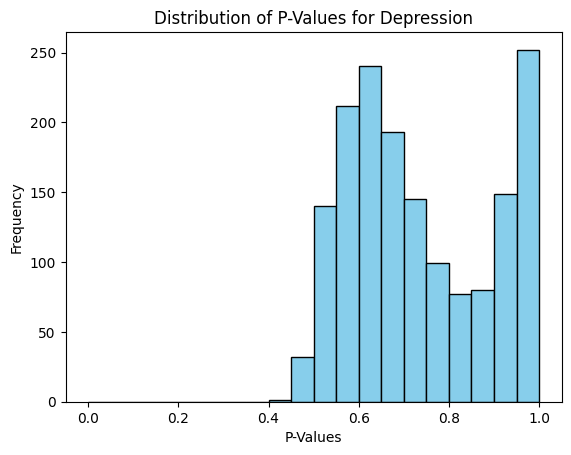

Number of edges greater than 0.4: 1620
Number of edges less than or equal to 0.4: 0


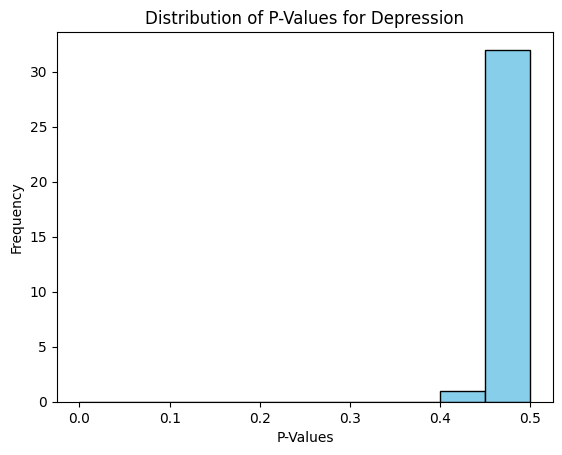

<Figure size 640x480 with 0 Axes>

In [8]:
df = pd.read_csv('atr_p_values.csv')
df_depr_plot = df.dropna(subset=['Depression Attribute'])
p_value_list_depr = df_depr_plot['P-Value'].tolist()

plt.hist(p_value_list_depr, bins=20, color='skyblue', edgecolor='black', range=(0, 1))
plt.xlabel('P-Values')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Depression')
plt.show()
plt.savefig('plots/depr_p_val.png', dpi=300)

threshold = 0.4
greater_than_thresh_depr = len([p_value for p_value in p_value_list_depr if p_value > threshold])
less_than_thresh_depr = len([p_value for p_value in p_value_list_depr if p_value < threshold])
print("Number of edges greater than 0.4:", greater_than_thresh_depr)
print("Number of edges less than or equal to 0.4:", less_than_thresh_depr)

plt.hist(p_value_list_depr, bins=10, color='skyblue', edgecolor='black', range=(0, 0.5))
plt.xlabel('P-Values')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Depression')
plt.show()
plt.savefig('plots/depr_p_val_close.png', dpi=300)

Plotting P-values: CVD

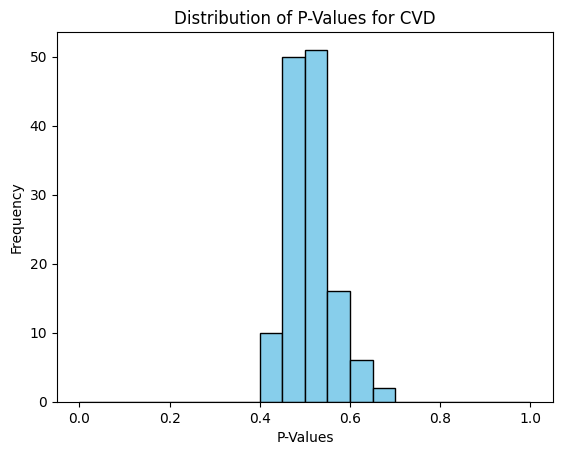

Number of edges greater than 0.4: 135
Number of edges less than or equal to 0.4: 0


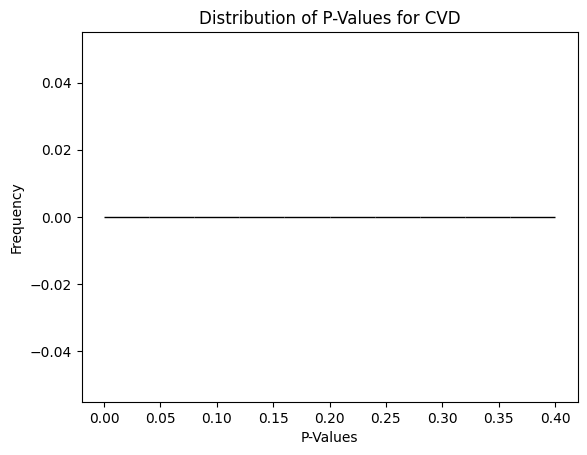

<Figure size 640x480 with 0 Axes>

In [9]:
df = pd.read_csv('outputs/atr_p_values.csv')
df_cvd_plot = df.dropna(subset=['CVD Attribute'])
p_value_list_cvd = df_cvd_plot['P-Value'].tolist()

plt.hist(p_value_list_cvd, bins=20, color='skyblue', edgecolor='black', range=(0, 1))
plt.xlabel('P-Values')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for CVD')
plt.show()
plt.savefig('plots/cvd_p_val.png', dpi=300)

threshold = 0.4
greater_than_thresh_cvd = len([p_value for p_value in p_value_list_cvd if p_value > threshold])
less_than_thresh_cvd = len([p_value for p_value in p_value_list_cvd if p_value < threshold])
print("Number of edges greater than 0.4:", greater_than_thresh_cvd)
print("Number of edges less than or equal to 0.4:", less_than_thresh_cvd)

plt.hist(p_value_list_cvd, bins=10, color='skyblue', edgecolor='black', range=(0, 0.4))
plt.xlabel('P-Values')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for CVD')
plt.show()
plt.savefig('plots/cvd_p_val_close.png', dpi=300)